In [1]:

import numpy as np
import math
import tensorflow as tf
import tensorflow_probability as tfp

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from jacques import kcqe

plt.style.use('ggplot')

In [2]:
# Data generation adapted from https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
# Fix random state for reproducibility
np.random.seed(9731)

np.random.rand(5)

def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

n = 500

#Create random predictors x0 and x1
x0 = randrange(n, -2. * np.pi, 2. * np.pi)
x1 = randrange(n, -2. * np.pi, 2. * np.pi)

#Create response variable y
y = 10. * np.cos(x0) + 0.5 * x1**2 + np.random.normal(loc=0., scale=5., size=n)

In [3]:
#Combine x0 and x1 into a single data array of predictors 


x = np.concatenate([x0[:, np.newaxis], x1[:, np.newaxis]], axis=1)

grid_size = 120

#Creates a grid of x values for test set
x_test = np.concatenate(
    [np.tile(np.linspace(-2. * np.pi, 2. * np.pi, num = grid_size), grid_size)[:, np.newaxis],
        np.repeat(np.linspace(-2. * np.pi, 2. * np.pi, num = grid_size), grid_size)[:, np.newaxis]],
    axis=1
)

In [4]:

# x_train_val
x = np.reshape(x, (1, 500, 2))
# y_train_val
y = np.reshape(y, (1, 500))

x_test = np.reshape(x_test, (1, 14400, 2))

x = tf.constant(x, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)
x_test = tf.constant(x_test, dtype=tf.float32)
    
block_size = 50
num_blocks = math.floor(y.shape[1]/block_size)

In [5]:
kcqe_obj = kcqe.KCQE(p=2)
generator = kcqe_obj.generator(x, y, batch_size = 10, block_size = block_size)

In [6]:
x_val, x_train, y_val, y_train = next(generator)
print(x_val.shape)
print(y_val.shape)
print(x_train.shape)
print(y_train.shape)

(500, 2)
(500,)
(3500, 2)
(3500,)


In [7]:
# plug in generator instead of raw data to get away from calculating 7-day avg
# initialize parameters at some bad values; otherwise, convergence is instantaneous
param_vec = kcqe_obj.fit(xval_batch_gen = generator,
    num_blocks = num_blocks, 
    tau=tf.constant(np.array([0.1, 0.5, 0.9]), dtype=tf.float32),
    optim_method="adam", 
    num_epochs=10, 
    learning_rate=0.1,
    init_param_vec=tf.constant(np.array([3.0, 3.0, 1.0]), dtype=tf.float32),
    verbose = True)

epoch idx = 0
batch idx = 0
loss idx = 1
param estimates vec = 
[3.0999963 3.099996  0.9000327]
loss = 
0.4420706
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.10298593, -0.10107633,  0.00986421], dtype=float32)>]
epoch idx = 0
batch idx = 1
loss idx = 1loss idx = 1
param estimates vec = 
[3.1998186 3.1998072 0.8000243]
loss = 
0.42085904
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.09763819, -0.09555424,  0.00999411], dtype=float32)>]
epoch idx = 0
batch idx = 2
loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[3.2992215 3.2993586 0.70025  ]
loss = 
0.4026249
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.09035584, -0.09117413,  0.00939451], dtype=float32)>]
epoch idx = 0
batch idx = 3
loss idx = 1loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[3.3982465  3.3985467  0.60027575]
loss = 
0.37964517
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.08699828, -0.08684116,  0.01011807], dtype=fl

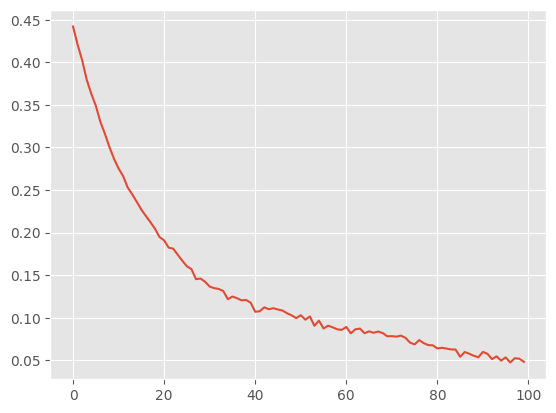

In [8]:
plt.plot(np.arange(len(kcqe_obj.loss_trace)), kcqe_obj.loss_trace)
plt.show()

In [9]:
q_hat = kcqe_obj.predict(param_vec,
                         x_train=x,
                         y_train=y,
                         x_test=x_test,
                         tau=tf.constant(np.array([0.1, 0.5, 0.9]), dtype=tf.float32))

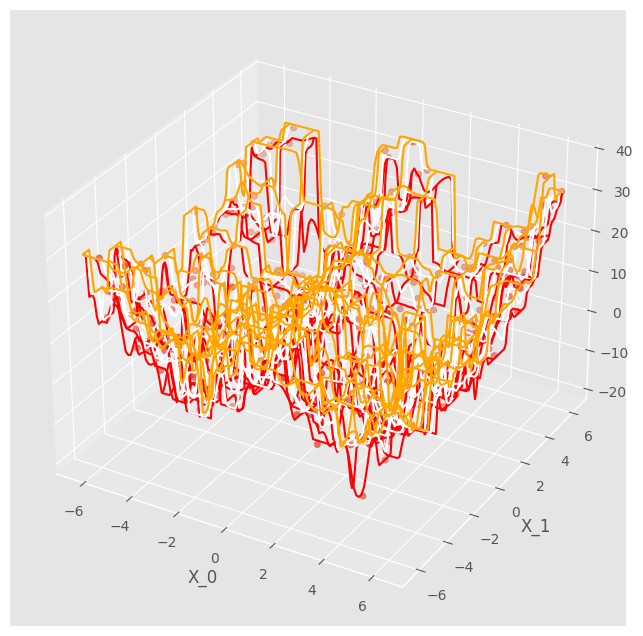

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig)

ax.scatter(x0, x1, y)

x0_grid = x_test[..., 0].numpy().reshape((grid_size, grid_size))
x1_grid = x_test[..., 1].numpy().reshape((grid_size, grid_size))
q_grid_q10 = q_hat[..., 0].numpy().reshape((grid_size, grid_size))
q_grid_median = q_hat[..., 1].numpy().reshape((grid_size, grid_size))
q_grid_q90 = q_hat[..., 2].numpy().reshape((grid_size, grid_size))

ax.plot_wireframe(x0_grid, x1_grid, q_grid_q10, rstride=10, cstride=10, color="red")
ax.plot_wireframe(x0_grid, x1_grid, q_grid_median, rstride=10, cstride=10)
ax.plot_wireframe(x0_grid, x1_grid, q_grid_q90, rstride=10, cstride=10, color="orange")

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

plt.show()

In [10]:
kcqe_obj = kcqe.KCQE(x_kernel='gaussian_full', p=2)
generator = kcqe_obj.generator(x, y, batch_size = 10, block_size = block_size)

In [14]:
# plug in generator instead of raw data to get away from calculating 7-day avg
# initialize parameters at some bad values; otherwise, convergence is instantaneous
param_vec = kcqe_obj.fit(xval_batch_gen = generator,
    num_blocks = num_blocks, 
    tau=tf.constant(np.array([0.1, 0.5, 0.9]), dtype=tf.float32),
    optim_method="adam", 
    num_epochs=10, 
    learning_rate=0.1,
    verbose = True)

epoch idx = 0
batch idx = 0
loss idx = 1
param estimates vec = 
[0.09999836 0.09999274 0.09998715 0.09953386]
loss = 
1.6402513
grads = 
[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.3250575 , -0.04792129, -0.02594887, -0.00067621], dtype=float32)>]
epoch idx = 0
batch idx = 1
loss idx = 1loss idx = 1
param estimates vec = 
[0.19958878 0.19301751 0.11481524 0.18942   ]
loss = 
1.6194605
grads = 
[<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([-2.9279688e-01, -2.3657570e-02,  1.7156720e-02, -2.7801079e-04],
      dtype=float32)>]
epoch idx = 0
batch idx = 2
loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[0.29796183 0.2761684  0.08389858 0.27906877]
loss = 
1.5841627
grads = 
[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.24453256, -0.01080618,  0.02483328, -0.00130381], dtype=float32)>]
epoch idx = 0
batch idx = 3
loss idx = 1loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[0.39443946 0.33660626 0.05513746 0.37005606]
loss = 
1.5639019
g

In [15]:
q_hat = kcqe_obj.predict(param_vec,
                         x_train=x,
                         y_train=y,
                         x_test=x_test,
                         tau=tf.constant(np.array([0.1, 0.5, 0.9]), dtype=tf.float32))

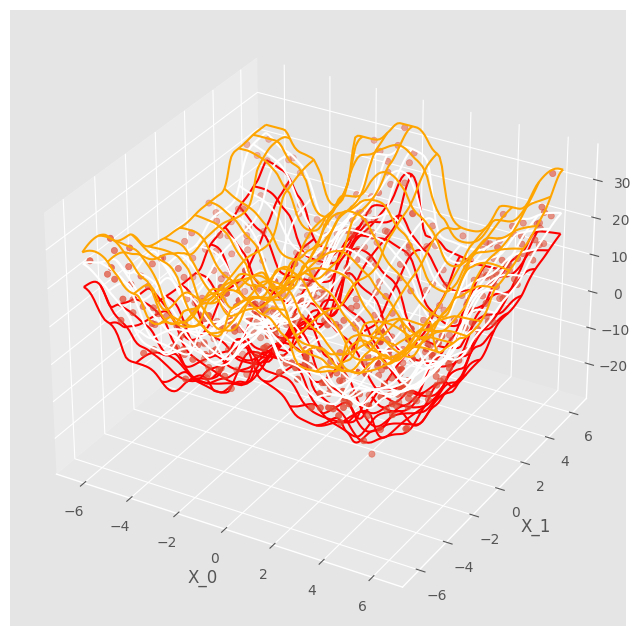

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig)

ax.scatter(x0, x1, y)

x0_grid = x_test[..., 0].numpy().reshape((grid_size, grid_size))
x1_grid = x_test[..., 1].numpy().reshape((grid_size, grid_size))
q_grid_q10 = q_hat[..., 0].numpy().reshape((grid_size, grid_size))
q_grid_median = q_hat[..., 1].numpy().reshape((grid_size, grid_size))
q_grid_q90 = q_hat[..., 2].numpy().reshape((grid_size, grid_size))

ax.plot_wireframe(x0_grid, x1_grid, q_grid_q10, rstride=10, cstride=10, color="red")
ax.plot_wireframe(x0_grid, x1_grid, q_grid_median, rstride=10, cstride=10)
ax.plot_wireframe(x0_grid, x1_grid, q_grid_q90, rstride=10, cstride=10, color="orange")

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

plt.show()

# Missing Data

Testing to see if method still works with missing values added.

In [28]:
import random

In [29]:
missing = random.sample(range(1, 501), 50)

In [37]:
# generate 50 random indices
random_indices = tf.random.shuffle(tf.range(500))[:50]

# scatter NaN values at the random indices
y_miss = 10. * np.cos(x0) + 0.5 * x1**2 + np.random.normal(loc=0., scale=5., size=n)

y_miss [random_indices] = np.nan


In [39]:
# y_train_val
y_miss = np.reshape(y, (1, 500))

y_miss = tf.constant(y_miss, dtype=tf.float32)

    
block_size = 50
num_blocks = math.floor(y.shape[1]/block_size)

In [40]:
kcqe_obj = kcqe.KCQE(p=2)
generator = kcqe_obj.generator(x, y_miss, batch_size = 10, block_size = block_size)

In [41]:
param_vec = kcqe_obj.fit(xval_batch_gen = generator,
    num_blocks = num_blocks, 
    tau=tf.constant(np.array([0.1, 0.5, 0.9]), dtype=tf.float32),
    optim_method="adam", 
    num_epochs=10, 
    learning_rate=0.1,
    init_param_vec=tf.constant(np.array([3.0, 3.0, 1.0]), dtype=tf.float32),
    verbose = True)

epoch idx = 0
batch idx = 0
loss idx = 1
param estimates vec = 
[2.9000022 2.9000053 1.0999295]
loss = 
1.8559208
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.19440739,  0.06930105, -0.00452088], dtype=float32)>]
epoch idx = 0
batch idx = 1
loss idx = 1loss idx = 1
param estimates vec = 
[2.8000438 2.8       1.199272 ]
loss = 
1.8236434
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.19167238,  0.06955975, -0.00393209], dtype=float32)>]
epoch idx = 0
batch idx = 2
loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[2.7000172 2.700042  1.2976269]
loss = 
1.7839864
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.19608937,  0.06858149, -0.00341937], dtype=float32)>]
epoch idx = 0
batch idx = 3
loss idx = 1loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[2.5998323 2.602054  1.396668 ]
loss = 
1.7598867
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.20315905,  0.05021626, -0.00421176], dtype=float32

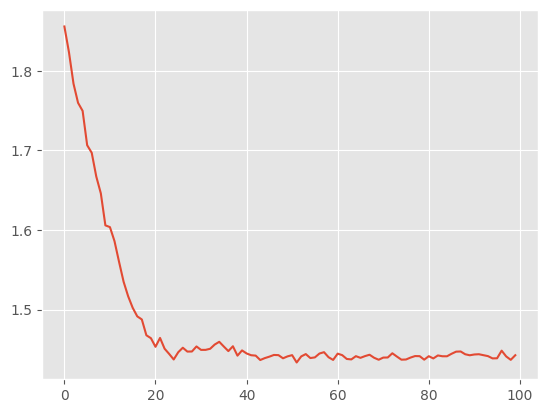

In [42]:
plt.plot(np.arange(len(kcqe_obj.loss_trace)), kcqe_obj.loss_trace)
plt.show()